**Gaussian Blur**

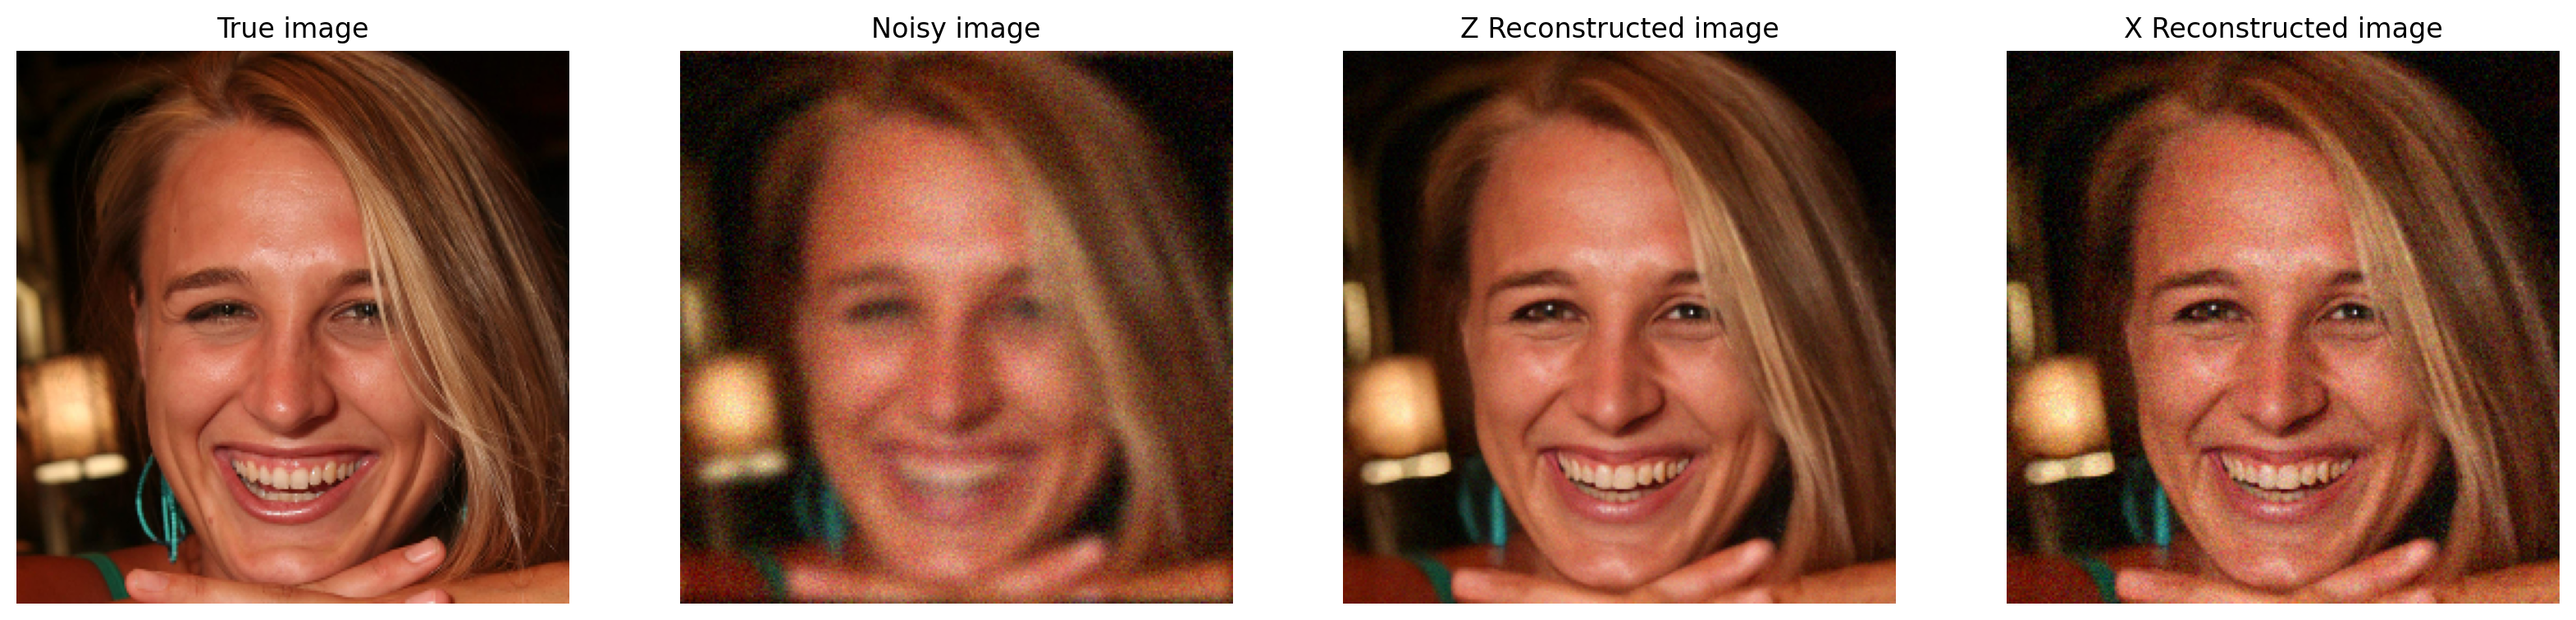

In [ ]:
import zipfile
import os
os.listdir('/content')

['.config', 'my_folder.zip', 'sample_data']

In [ ]:
zip_file_path = "/content/my_folder.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped')  # Dosyaları 'unzipped' klasörüne çıkarır
%cd unzipped/content/PnP-SGS/PnP-SGS


/content/unzipped/content/PnP-SGS/PnP-SGS


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 MB 51.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!python3 posterior_sampler.py \
--data_config=configs/data_config.yaml \
--model_config=configs/model_config.yaml \
--diffusion_config=configs/diffusion_config.yaml \
--gibbs_config=configs/gibbs_config.yaml \
--operator_config=configs/gaussianblur_config.yaml;

Load model
Load sampler
Load operator
Load dataset
100% 23/23 [00:40<00:00,  1.74s/it]
100% 23/23 [00:40<00:00,  1.75s/it]
100% 23/23 [00:40<00:00,  1.77s/it]



📊 **FID Sonuçları** 📊
╒════╤════════════╤═══════════════════════╤═════════════════════════════════╤═════════════════════════════════╤══════════════════════════════════╤══════════════════════════════════╕
│    │   Image ID │   FID (Noisy vs True) │   FID (Reconstructed X vs True) │   FID (Reconstructed Z vs True) │   FID (Noisy vs Reconstructed X) │   FID (Noisy vs Reconstructed Z) │
╞════╪════════════╪═══════════════════════╪═════════════════════════════════╪═════════════════════════════════╪══════════════════════════════════╪══════════════════════════════════╡
│  0 │      00001 │               117.661 │                         39.8549 │                         7.04626 │                          55.0358 │                          78.6651 │
├────┼────────────┼───────────────────────┼─────────────────────────────────┼─────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│  1 │      00002 │               141.759 │                        

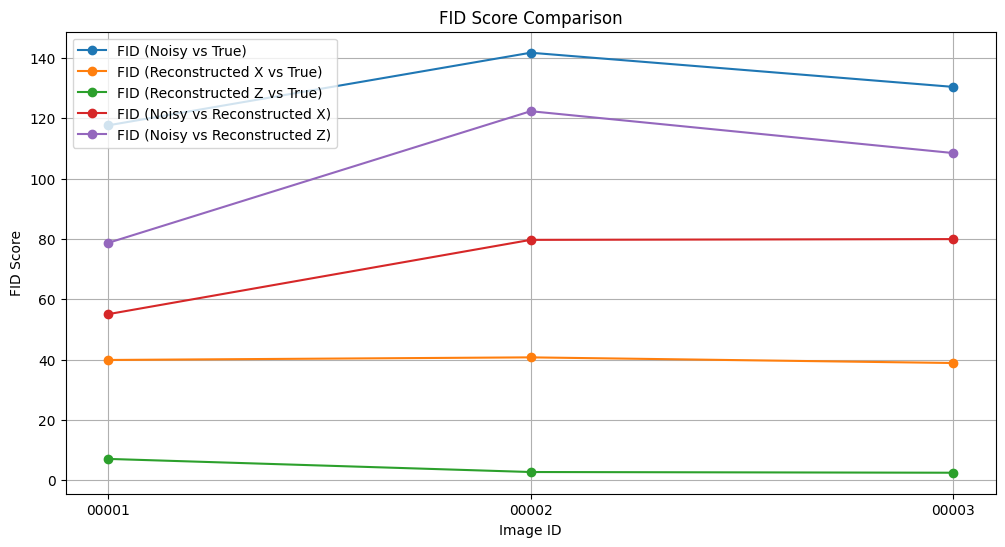

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from PIL import Image
from tabulate import tabulate  # Tablo olarak yazdırmak için

# ✅ 1. Görselleri yükleyip işleme hazırlayan fonksiyon
def load_and_preprocess_image(image_path):
    """Görüntüyü RGB formatına çevir ve 299x299 boyutuna getir."""
    img = Image.open(image_path).resize((299, 299))  # Inception için standart boyut
    img = img.convert("RGB")  # Eğer gri tonlamalıysa RGB'ye çevir
    return np.array(img).astype(np.float32)

# ✅ 2. PyTorch kullanmadan FID hesaplama fonksiyonu
def calculate_fid_nopytorch(image1_path, image2_path):
    """PyTorch olmadan FID hesaplar."""
    img1 = load_and_preprocess_image(image1_path)
    img2 = load_and_preprocess_image(image2_path)

    # Renk kanallarını ayrı ayrı al (Her pikseli vektör gibi düşün)
    img1 = img1.reshape(-1, 3)
    img2 = img2.reshape(-1, 3)

    # Ortalama ve kovaryans hesapla
    mu1, sigma1 = np.mean(img1, axis=0), np.cov(img1, rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=0), np.cov(img2, rowvar=False)

    # Frechet mesafesi hesapla
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1 @ sigma2)  # Kovaryans matrislerinin çarpımının karekökü
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Karmaşık sayılar çıkarsa sadece reel kısmı al

    fid_score = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# ✅ 3. Görüntü dosyalarının yollarını belirleyelim
image_ids = ["00001", "00002", "00003"]
fid_results = []

for img_id in image_ids:
    original = f"data/samples_ffhq/{img_id}.png"
    noisy = f"results/noisy_image_{int(img_id[-1]) - 1}.png"
    rec_x = f"results/reconstructed_x_{int(img_id[-1]) - 1}.png"
    rec_z = f"results/reconstructed_z_{int(img_id[-1]) - 1}.png"

    # FID hesaplamaları
    fid_noisy_true = calculate_fid_nopytorch(original, noisy)
    fid_recx_true = calculate_fid_nopytorch(original, rec_x)
    fid_recz_true = calculate_fid_nopytorch(original, rec_z)
    fid_noisy_recx = calculate_fid_nopytorch(noisy, rec_x)
    fid_noisy_recz = calculate_fid_nopytorch(noisy, rec_z)

    fid_results.append([img_id, fid_noisy_true, fid_recx_true, fid_recz_true, fid_noisy_recx, fid_noisy_recz])

# ✅ 4. Sonuçları bir tablo olarak düzenleyelim
fid_df = pd.DataFrame(fid_results, columns=[
    "Image ID",
    "FID (Noisy vs True)",
    "FID (Reconstructed X vs True)",
    "FID (Reconstructed Z vs True)",
    "FID (Noisy vs Reconstructed X)",
    "FID (Noisy vs Reconstructed Z)"
])

# ✅ 5. Sonuçları terminalde tablo olarak bastır
print("\n📊 **FID Sonuçları** 📊")
print(tabulate(fid_df, headers="keys", tablefmt="fancy_grid"))

# ✅ 6. Sonuçları görselleştirme (Chart oluşturma)
plt.figure(figsize=(12, 6))

for col in fid_df.columns[1:]:  # İlk sütun "Image ID", onu çizmek gereksiz
    plt.plot(fid_df["Image ID"], fid_df[col], marker='o', label=col)

plt.xlabel("Image ID")
plt.ylabel("FID Score")
plt.title("FID Score Comparison")
plt.legend()
plt.grid(True)
plt.show()



📊 **PSNR Sonuçları** 📊
Image 00001: PSNR Noisy vs True = 22.38 dB, PSNR Denoised vs True = 23.83 dB
Image 00002: PSNR Noisy vs True = 21.71 dB, PSNR Denoised vs True = 22.95 dB
Image 00003: PSNR Noisy vs True = 22.17 dB, PSNR Denoised vs True = 23.51 dB


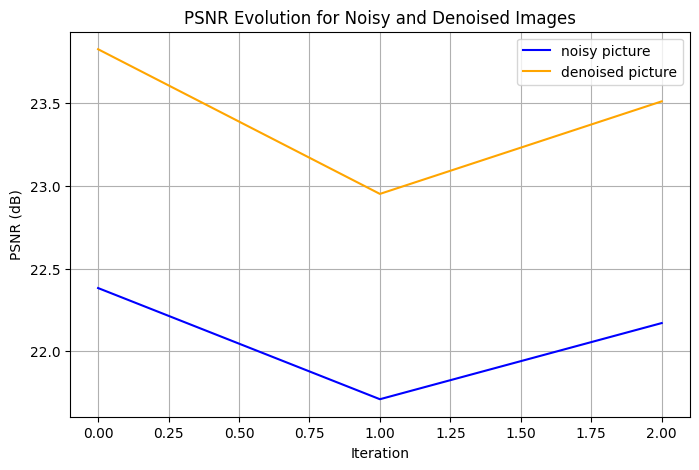

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
from tabulate import tabulate

# ✅ Kullanılacak belirli görüntü indeksleri
selected_indices = ["00001", "00002", "00003"]  # İşlenmesini istediğin görüntüler

# ✅ Veri setinin bulunduğu klasör
image_folder = "data/samples_ffhq/"
result_folder = "resultsGaussian/"

# ✅ PSNR hesaplama fonksiyonu
def mypsnr(x, y, max_pixel=1.0):
    """
    PSNR hesaplama fonksiyonu.

    x: Tahmini görüntü (tensör)
    y: Gerçek görüntü (tensör)
    max_pixel: Maksimum piksel değeri (1.0 veya 255)
    """
    mse = torch.mean((x - y) ** 2).item()  # MSE hesapla

    if mse == 0:
        return float('inf')  # Eğer tamamen aynıysa, PSNR sonsuz olur

    psnr = 10 * np.log10(max_pixel**2 / mse)  # PSNR formülü
    return psnr

# ✅ Görüntüyü yükleyip PyTorch tensörüne çevirme fonksiyonu
def load_image_as_tensor(image_path, target_size=(256, 256)):
    """Görüntüyü aç, boyutunu target_size'a ayarla, normalize et ve PyTorch tensörüne dönüştür."""
    img = Image.open(image_path).convert("RGB")  # RGB'ye çevir
    img = img.resize(target_size)  # Boyutları eşitle
    img = np.array(img).astype(np.float32) / 255.0  # Normalize et (0-1)
    img = torch.tensor(img).permute(2, 0, 1)  # Kanal sırasını (C, H, W) yap
    return img

# ✅ Sonuçları saklamak için boş listeler
psnr_noisy_all = []
psnr_denoised_all = []

# ✅ PSNR hesaplamalarını yap
for img_id in selected_indices:
    original = os.path.join(image_folder, f"{img_id}.png")
    noisy = os.path.join(result_folder, f"noisy_image_{int(img_id[-1]) - 1}.png")
    rec_x = os.path.join(result_folder, f"reconstructed_x_{int(img_id[-1]) - 1}.png")
    rec_z = os.path.join(result_folder, f"reconstructed_z_{int(img_id[-1]) - 1}.png")

    # Görselleri yükle ve tensöre çevir
    x0 = load_image_as_tensor(original)
    x_noisy = load_image_as_tensor(noisy)
    x_rec_x = load_image_as_tensor(rec_x)
    x_rec_z = load_image_as_tensor(rec_z)

    # ✅ PSNR hesaplamaları
    psnr_noisy_true = mypsnr(x_noisy, x0, max_pixel=1.0)
    psnr_recx_true = mypsnr(x_rec_x, x0, max_pixel=1.0)
    psnr_recz_true = mypsnr(x_rec_z, x0, max_pixel=1.0)

    # Sonuçları listeye ekle
    psnr_noisy_all.append(psnr_noisy_true)
    psnr_denoised_all.append(psnr_recx_true)  # X rekonstrüksiyonu üzerinden alıyoruz

# ✅ Sonuçları terminalde yazdır
print("\n📊 **PSNR Sonuçları** 📊")
for i, img_id in enumerate(selected_indices):
    print(f"Image {img_id}: PSNR Noisy vs True = {psnr_noisy_all[i]:.2f} dB, PSNR Denoised vs True = {psnr_denoised_all[i]:.2f} dB")

# ✅ PSNR Grafiği (Resimdeki gibi)
plt.figure(figsize=(8, 5))
plt.plot(psnr_noisy_all, label="noisy picture", color="blue")
plt.plot(psnr_denoised_all, label="denoised picture", color="orange")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Evolution for Noisy and Denoised Images")
plt.legend()
plt.grid(True)
plt.show()



📊 **SSIM Sonuçları** 📊
Image 00001: SSIM Noisy vs True = 0.4775, SSIM Denoised vs True = 0.5611
Image 00002: SSIM Noisy vs True = 0.4770, SSIM Denoised vs True = 0.5365
Image 00003: SSIM Noisy vs True = 0.5123, SSIM Denoised vs True = 0.5857


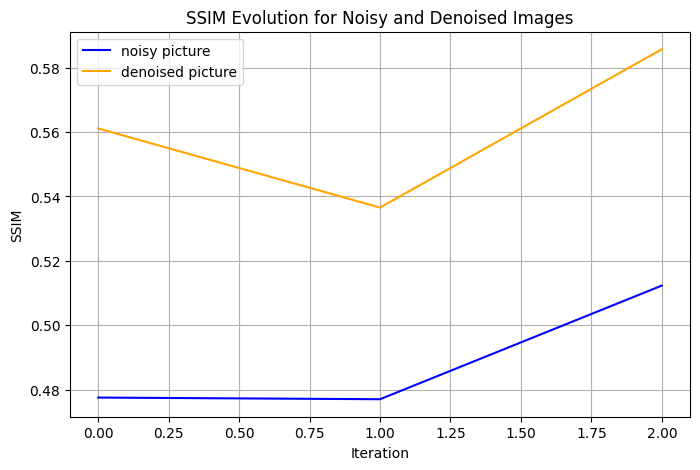

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# ✅ Kullanılacak belirli görüntü indeksleri
selected_indices = ["00001", "00002", "00003"]  # İşlenmesini istediğin görüntüler

# ✅ Veri setinin bulunduğu klasör
image_folder = "data/samples_ffhq/"
result_folder = "resultsGaussian/"

# ✅ SSIM hesaplama fonksiyonu
def myssim(x, y):
    """
    SSIM hesaplama fonksiyonu.

    x: Tahmini görüntü (tensör)
    y: Gerçek görüntü (tensör)
    """
    x_np = x.permute(1, 2, 0).numpy()  # Tensörü numpy dizisine çevir (H, W, C)
    y_np = y.permute(1, 2, 0).numpy()  # Tensörü numpy dizisine çevir (H, W, C)

    ssim_value = ssim(x_np, y_np, win_size=11, channel_axis=2, data_range=1.0)  # SSIM hesapla
    return ssim_value


# ✅ Görüntüyü yükleyip PyTorch tensörüne çevirme fonksiyonu
def load_image_as_tensor(image_path, target_size=(256, 256)):
    """Görüntüyü aç, boyutunu target_size'a ayarla, normalize et ve PyTorch tensörüne dönüştür."""
    img = Image.open(image_path).convert("RGB")  # RGB'ye çevir
    img = img.resize(target_size)  # Boyutları eşitle
    img = np.array(img).astype(np.float32) / 255.0  # Normalize et (0-1)
    img = torch.tensor(img).permute(2, 0, 1)  # Kanal sırasını (C, H, W) yap
    return img

# ✅ Sonuçları saklamak için boş listeler
ssim_noisy_all = []
ssim_denoised_all = []

# ✅ SSIM hesaplamalarını yap
for img_id in selected_indices:
    original = os.path.join(image_folder, f"{img_id}.png")
    noisy = os.path.join(result_folder, f"noisy_image_{int(img_id[-1]) - 1}.png")
    rec_x = os.path.join(result_folder, f"reconstructed_x_{int(img_id[-1]) - 1}.png")
    rec_z = os.path.join(result_folder, f"reconstructed_z_{int(img_id[-1]) - 1}.png")

    # Görselleri yükle ve tensöre çevir
    x0 = load_image_as_tensor(original)
    x_noisy = load_image_as_tensor(noisy)
    x_rec_x = load_image_as_tensor(rec_x)
    x_rec_z = load_image_as_tensor(rec_z)

    # ✅ SSIM hesaplamaları
    ssim_noisy_true = myssim(x_noisy, x0)
    ssim_recx_true = myssim(x_rec_x, x0)
    ssim_recz_true = myssim(x_rec_z, x0)

    # Sonuçları listeye ekle
    ssim_noisy_all.append(ssim_noisy_true)
    ssim_denoised_all.append(ssim_recx_true)  # X rekonstrüksiyonu üzerinden alıyoruz

# ✅ Sonuçları terminalde yazdır
print("\n📊 **SSIM Sonuçları** 📊")
for i, img_id in enumerate(selected_indices):
    print(f"Image {img_id}: SSIM Noisy vs True = {ssim_noisy_all[i]:.4f}, SSIM Denoised vs True = {ssim_denoised_all[i]:.4f}")

# ✅ SSIM Grafiği
plt.figure(figsize=(8, 5))
plt.plot(ssim_noisy_all, label="noisy picture", color="blue")
plt.plot(ssim_denoised_all, label="denoised picture", color="orange")
plt.xlabel("Iteration")
plt.ylabel("SSIM")
plt.title("SSIM Evolution for Noisy and Denoised Images")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%cd ../../../..


/content


In [ ]:
%cd unzipped/content/PnP-SGS/PnP-SGS

/content/unzipped/content/PnP-SGS/PnP-SGS



📊 **FID Sonuçları** 📊
╒════╤════════════╤═══════════════════════╤═════════════════════════════════╤═════════════════════════════════╤══════════════════════════════════╤══════════════════════════════════╕
│    │   Image ID │   FID (Noisy vs True) │   FID (Reconstructed X vs True) │   FID (Reconstructed Z vs True) │   FID (Noisy vs Reconstructed X) │   FID (Noisy vs Reconstructed Z) │
╞════╪════════════╪═══════════════════════╪═════════════════════════════════╪═════════════════════════════════╪══════════════════════════════════╪══════════════════════════════════╡
│  0 │      00001 │               90.5981 │                         33.5464 │                         3.90935 │                          51.3041 │                          79.0629 │
├────┼────────────┼───────────────────────┼─────────────────────────────────┼─────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│  1 │      00002 │               99.7968 │                        

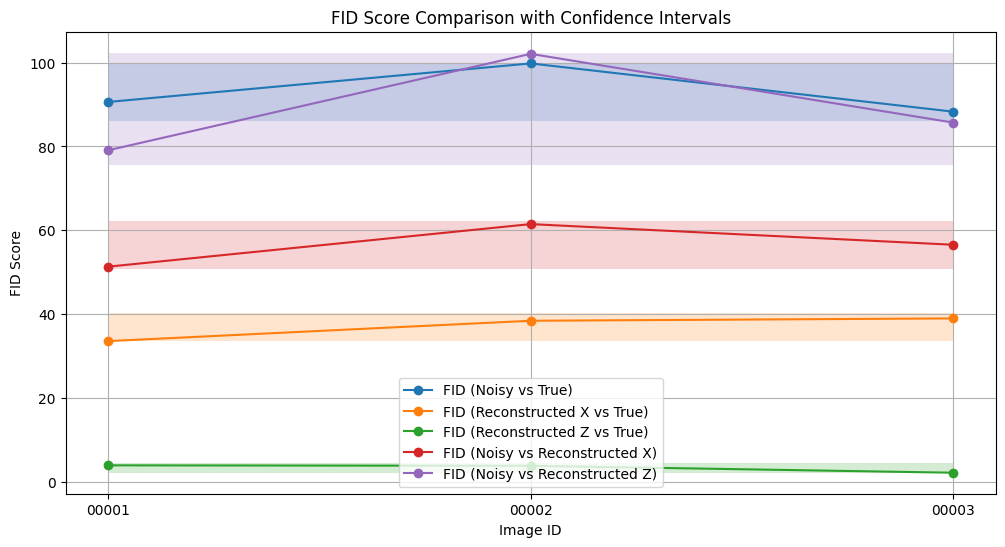

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.stats import sem  # Standart hata hesaplamak için
from PIL import Image
from tabulate import tabulate

# ✅ 1. Görselleri yükleyip işleme hazırlayan fonksiyon
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).resize((299, 299))
    img = img.convert("RGB")
    return np.array(img).astype(np.float32)

# ✅ 2. PyTorch olmadan FID hesaplama fonksiyonu
def calculate_fid_nopytorch(image1_path, image2_path):
    img1 = load_and_preprocess_image(image1_path)
    img2 = load_and_preprocess_image(image2_path)
    img1 = img1.reshape(-1, 3)
    img2 = img2.reshape(-1, 3)
    mu1, sigma1 = np.mean(img1, axis=0), np.cov(img1, rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=0), np.cov(img2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# ✅ 3. Görüntü dosyalarının yollarını belirleyelim
image_ids = ["00001", "00002", "00003"]
fid_results = []

for img_id in image_ids:
    original = f"data/samples_ffhq/{img_id}.png"
    noisy = f"resultsGaussian/noisy_image_{int(img_id[-1]) - 1}.png"
    rec_x = f"resultsGaussian/reconstructed_x_{int(img_id[-1]) - 1}.png"
    rec_z = f"resultsGaussian/reconstructed_z_{int(img_id[-1]) - 1}.png"

    fid_noisy_true = calculate_fid_nopytorch(original, noisy)
    fid_recx_true = calculate_fid_nopytorch(original, rec_x)
    fid_recz_true = calculate_fid_nopytorch(original, rec_z)
    fid_noisy_recx = calculate_fid_nopytorch(noisy, rec_x)
    fid_noisy_recz = calculate_fid_nopytorch(noisy, rec_z)

    fid_results.append([img_id, fid_noisy_true, fid_recx_true, fid_recz_true, fid_noisy_recx, fid_noisy_recz])

# ✅ 4. Sonuçları bir tablo olarak düzenleyelim
fid_df = pd.DataFrame(fid_results, columns=[
    "Image ID",
    "FID (Noisy vs True)",
    "FID (Reconstructed X vs True)",
    "FID (Reconstructed Z vs True)",
    "FID (Noisy vs Reconstructed X)",
    "FID (Noisy vs Reconstructed Z)"
])

# ✅ 5. Confidence Interval hesaplama fonksiyonu
def confidence_interval(data):
    mean = np.mean(data)
    error = 1.96 * sem(data)  # 95% güven aralığı
    return mean, mean - error, mean + error

# ✅ 6. Confidence Interval hesapla
confidence_intervals = {}
for col in fid_df.columns[1:]:  # "Image ID" hariç tüm kolonlar için
    mean, lower, upper = confidence_interval(fid_df[col])
    confidence_intervals[col] = [mean, lower, upper]

confidence_df = pd.DataFrame(confidence_intervals, index=["Mean", "Lower CI", "Upper CI"])

# ✅ 7. Sonuçları terminalde yazdır
print("\n📊 **FID Sonuçları** 📊")
print(tabulate(fid_df, headers="keys", tablefmt="fancy_grid"))
print("\n📌 **Confidence Intervals (95%)**")
print(tabulate(confidence_df, headers="keys", tablefmt="fancy_grid"))

# ✅ 8. Sonuçları görselleştirme (Chart oluşturma)
plt.figure(figsize=(12, 6))
for col in fid_df.columns[1:]:
    mean, lower, upper = confidence_interval(fid_df[col])
    plt.plot(fid_df["Image ID"], fid_df[col], marker='o', label=col)
    plt.fill_between(fid_df["Image ID"], lower, upper, alpha=0.2)  # Güven aralığını çiz

plt.xlabel("Image ID")
plt.ylabel("FID Score")
plt.title("FID Score Comparison with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

**Motion Blur**

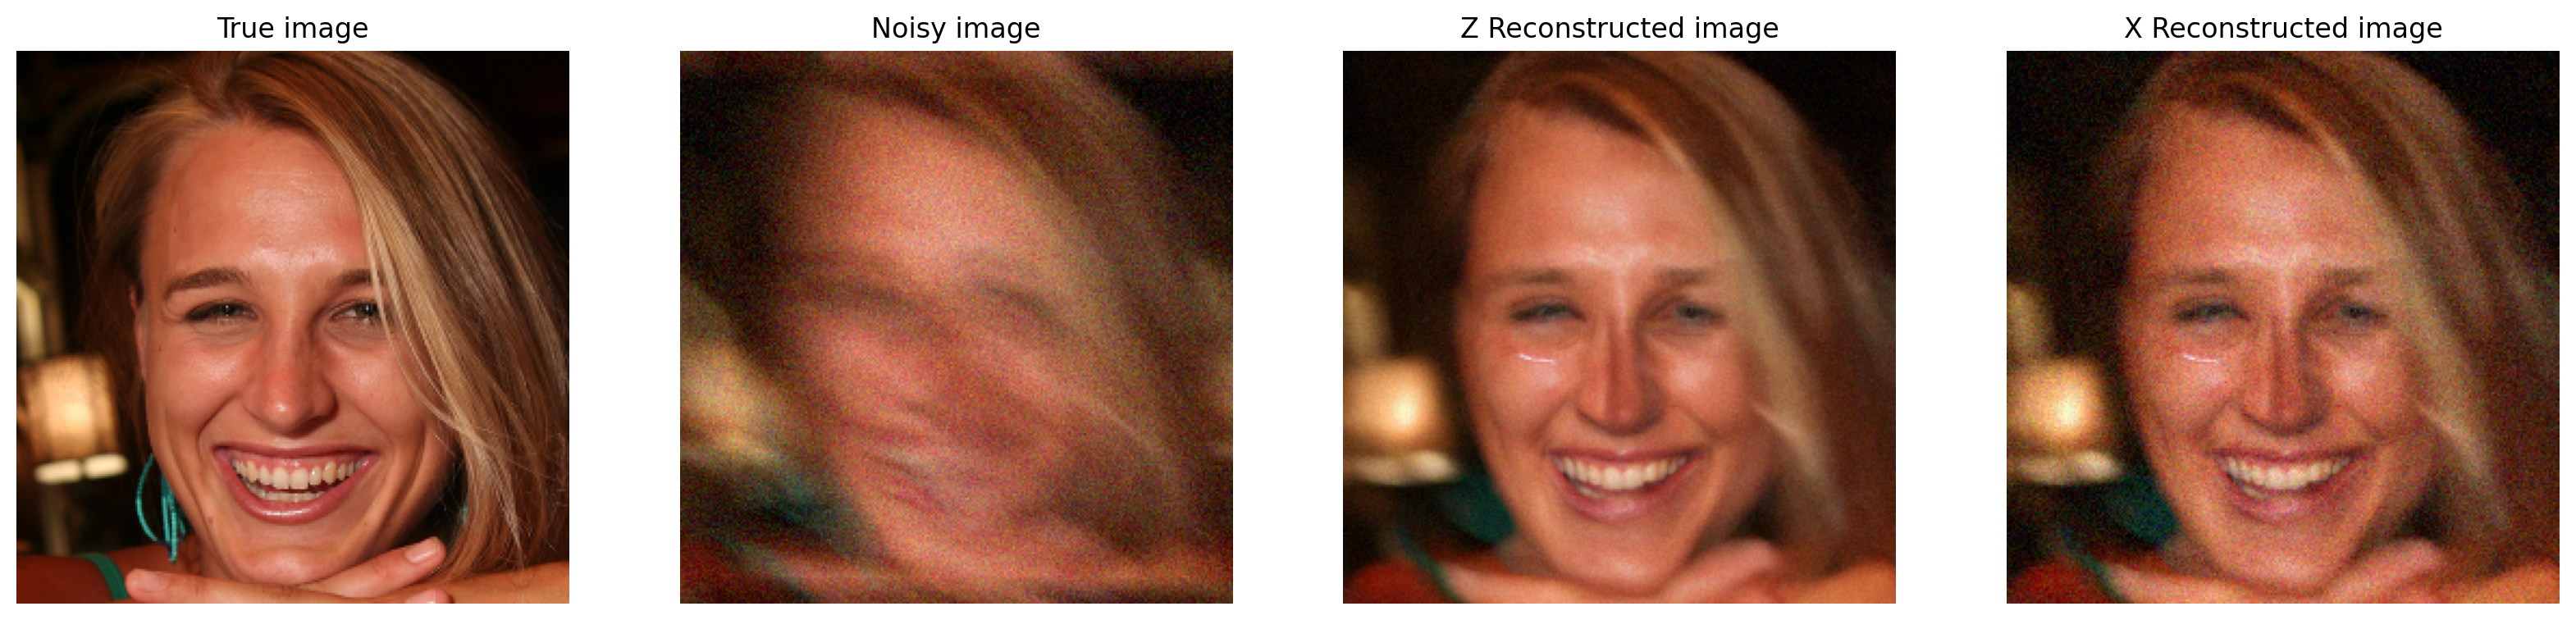

In [ ]:
import zipfile
import os
os.listdir('/content')

['.config', 'my_folder.zip', 'unzipped', 'my_folder_motion.zip', 'sample_data']

In [ ]:
zip_file_path = "/content/my_folder_motion.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped_motion')  # Dosyaları 'unzipped' klasörüne çıkarır



In [ ]:
!python3 posterior_sampler.py \
--data_config=configs/data_config.yaml \
--model_config=configs/model_config.yaml \
--diffusion_config=configs/diffusion_config.yaml \
--gibbs_config=configs/gibbs_config.yaml \
--operator_config=configs/motionblur_config.yaml;

Load model
Load sampler
Load operator
Load dataset
100% 23/23 [00:40<00:00,  1.77s/it]
100% 23/23 [00:40<00:00,  1.75s/it]
100% 23/23 [00:40<00:00,  1.74s/it]



📊 **FID Sonuçları** 📊
╒════╤════════════╤═══════════════════════╤═════════════════════════════════╤═════════════════════════════════╤══════════════════════════════════╤══════════════════════════════════╕
│    │   Image ID │   FID (Noisy vs True) │   FID (Reconstructed X vs True) │   FID (Reconstructed Z vs True) │   FID (Noisy vs Reconstructed X) │   FID (Noisy vs Reconstructed Z) │
╞════╪════════════╪═══════════════════════╪═════════════════════════════════╪═════════════════════════════════╪══════════════════════════════════╪══════════════════════════════════╡
│  0 │      00001 │               395.972 │                         54.6286 │                        27.7627  │                          215.196 │                          239.977 │
├────┼────────────┼───────────────────────┼─────────────────────────────────┼─────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│  1 │      00002 │               786.499 │                        

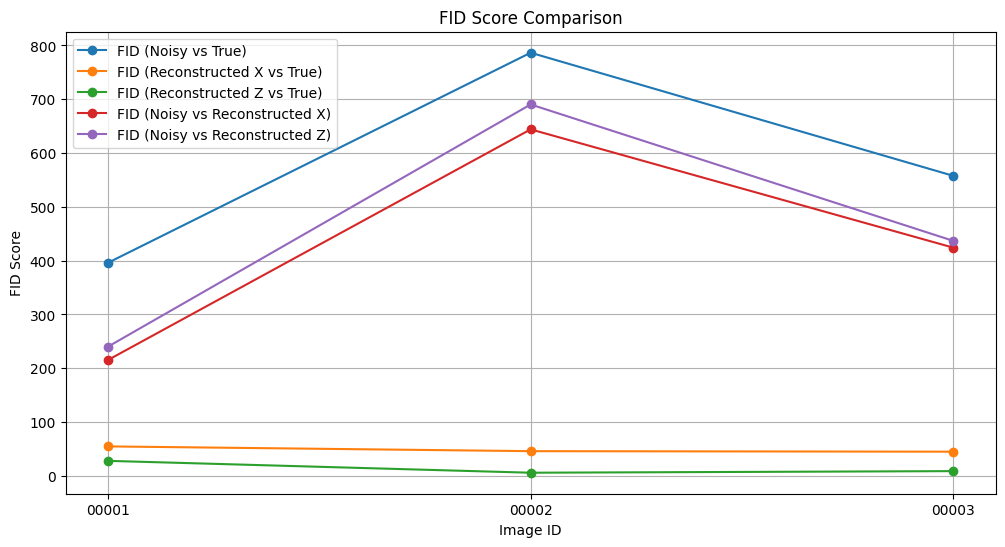

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from PIL import Image
from tabulate import tabulate  # Tablo olarak yazdırmak için

# ✅ 1. Görselleri yükleyip işleme hazırlayan fonksiyon
def load_and_preprocess_image(image_path):
    """Görüntüyü RGB formatına çevir ve 299x299 boyutuna getir."""
    img = Image.open(image_path).resize((299, 299))  # Inception için standart boyut
    img = img.convert("RGB")  # Eğer gri tonlamalıysa RGB'ye çevir
    return np.array(img).astype(np.float32)

# ✅ 2. PyTorch kullanmadan FID hesaplama fonksiyonu
def calculate_fid_nopytorch(image1_path, image2_path):
    """PyTorch olmadan FID hesaplar."""
    img1 = load_and_preprocess_image(image1_path)
    img2 = load_and_preprocess_image(image2_path)

    # Renk kanallarını ayrı ayrı al (Her pikseli vektör gibi düşün)
    img1 = img1.reshape(-1, 3)
    img2 = img2.reshape(-1, 3)

    # Ortalama ve kovaryans hesapla
    mu1, sigma1 = np.mean(img1, axis=0), np.cov(img1, rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=0), np.cov(img2, rowvar=False)

    # Frechet mesafesi hesapla
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1 @ sigma2)  # Kovaryans matrislerinin çarpımının karekökü
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Karmaşık sayılar çıkarsa sadece reel kısmı al

    fid_score = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# ✅ 3. Görüntü dosyalarının yollarını belirleyelim
image_ids = ["00001", "00002", "00003"]
fid_results = []

for img_id in image_ids:
    original = f"data/samples_ffhq/{img_id}.png"
    noisy = f"resultsMotion/noisy_image_{int(img_id[-1]) - 1}.png"
    rec_x = f"resultsMotion/reconstructed_x_{int(img_id[-1]) - 1}.png"
    rec_z = f"resultsMotion/reconstructed_z_{int(img_id[-1]) - 1}.png"

    # FID hesaplamaları
    fid_noisy_true = calculate_fid_nopytorch(original, noisy)
    fid_recx_true = calculate_fid_nopytorch(original, rec_x)
    fid_recz_true = calculate_fid_nopytorch(original, rec_z)
    fid_noisy_recx = calculate_fid_nopytorch(noisy, rec_x)
    fid_noisy_recz = calculate_fid_nopytorch(noisy, rec_z)

    fid_results.append([img_id, fid_noisy_true, fid_recx_true, fid_recz_true, fid_noisy_recx, fid_noisy_recz])

# ✅ 4. Sonuçları bir tablo olarak düzenleyelim
fid_df = pd.DataFrame(fid_results, columns=[
    "Image ID",
    "FID (Noisy vs True)",
    "FID (Reconstructed X vs True)",
    "FID (Reconstructed Z vs True)",
    "FID (Noisy vs Reconstructed X)",
    "FID (Noisy vs Reconstructed Z)"
])

# ✅ 5. Sonuçları terminalde tablo olarak bastır
print("\n📊 **FID Sonuçları** 📊")
print(tabulate(fid_df, headers="keys", tablefmt="fancy_grid"))

# ✅ 6. Sonuçları görselleştirme (Chart oluşturma)
plt.figure(figsize=(12, 6))

for col in fid_df.columns[1:]:  # İlk sütun "Image ID", onu çizmek gereksiz
    plt.plot(fid_df["Image ID"], fid_df[col], marker='o', label=col)

plt.xlabel("Image ID")
plt.ylabel("FID Score")
plt.title("FID Score Comparison")
plt.legend()
plt.grid(True)
plt.show()



📊 **PSNR Sonuçları** 📊
Image 00001: PSNR Noisy vs True = 18.13 dB, PSNR Denoised vs True = 21.89 dB
Image 00002: PSNR Noisy vs True = 16.63 dB, PSNR Denoised vs True = 20.90 dB
Image 00003: PSNR Noisy vs True = 17.52 dB, PSNR Denoised vs True = 21.10 dB


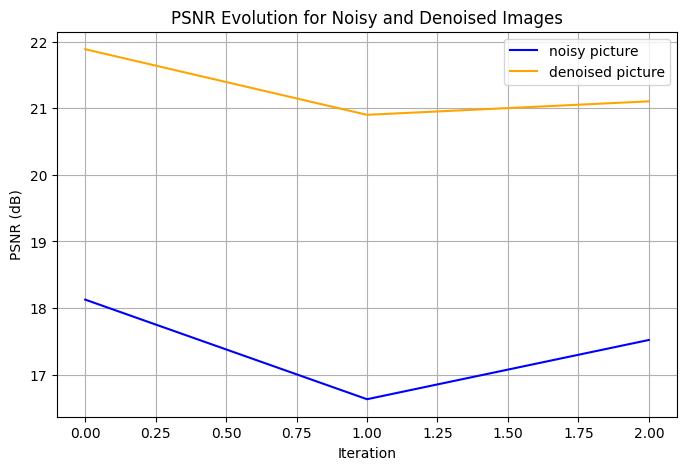

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
from tabulate import tabulate

# ✅ Kullanılacak belirli görüntü indeksleri
selected_indices = ["00001", "00002", "00003"]  # İşlenmesini istediğin görüntüler

# ✅ Veri setinin bulunduğu klasör
image_folder = "data/samples_ffhq/"
result_folder = "resultsMotion/"

# ✅ PSNR hesaplama fonksiyonu
def mypsnr(x, y, max_pixel=1.0):
    """
    PSNR hesaplama fonksiyonu.

    x: Tahmini görüntü (tensör)
    y: Gerçek görüntü (tensör)
    max_pixel: Maksimum piksel değeri (1.0 veya 255)
    """
    mse = torch.mean((x - y) ** 2).item()  # MSE hesapla

    if mse == 0:
        return float('inf')  # Eğer tamamen aynıysa, PSNR sonsuz olur

    psnr = 10 * np.log10(max_pixel**2 / mse)  # PSNR formülü
    return psnr

# ✅ Görüntüyü yükleyip PyTorch tensörüne çevirme fonksiyonu
def load_image_as_tensor(image_path, target_size=(256, 256)):
    """Görüntüyü aç, boyutunu target_size'a ayarla, normalize et ve PyTorch tensörüne dönüştür."""
    img = Image.open(image_path).convert("RGB")  # RGB'ye çevir
    img = img.resize(target_size)  # Boyutları eşitle
    img = np.array(img).astype(np.float32) / 255.0  # Normalize et (0-1)
    img = torch.tensor(img).permute(2, 0, 1)  # Kanal sırasını (C, H, W) yap
    return img

# ✅ Sonuçları saklamak için boş listeler
psnr_noisy_all = []
psnr_denoised_all = []

# ✅ PSNR hesaplamalarını yap
for img_id in selected_indices:
    original = os.path.join(image_folder, f"{img_id}.png")
    noisy = os.path.join(result_folder, f"noisy_image_{int(img_id[-1]) - 1}.png")
    rec_x = os.path.join(result_folder, f"reconstructed_x_{int(img_id[-1]) - 1}.png")
    rec_z = os.path.join(result_folder, f"reconstructed_z_{int(img_id[-1]) - 1}.png")

    # Görselleri yükle ve tensöre çevir
    x0 = load_image_as_tensor(original)
    x_noisy = load_image_as_tensor(noisy)
    x_rec_x = load_image_as_tensor(rec_x)
    x_rec_z = load_image_as_tensor(rec_z)

    # ✅ PSNR hesaplamaları
    psnr_noisy_true = mypsnr(x_noisy, x0, max_pixel=1.0)
    psnr_recx_true = mypsnr(x_rec_x, x0, max_pixel=1.0)
    psnr_recz_true = mypsnr(x_rec_z, x0, max_pixel=1.0)

    # Sonuçları listeye ekle
    psnr_noisy_all.append(psnr_noisy_true)
    psnr_denoised_all.append(psnr_recx_true)  # X rekonstrüksiyonu üzerinden alıyoruz

# ✅ Sonuçları terminalde yazdır
print("\n📊 **PSNR Sonuçları** 📊")
for i, img_id in enumerate(selected_indices):
    print(f"Image {img_id}: PSNR Noisy vs True = {psnr_noisy_all[i]:.2f} dB, PSNR Denoised vs True = {psnr_denoised_all[i]:.2f} dB")

# ✅ PSNR Grafiği (Resimdeki gibi)
plt.figure(figsize=(8, 5))
plt.plot(psnr_noisy_all, label="noisy picture", color="blue")
plt.plot(psnr_denoised_all, label="denoised picture", color="orange")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Evolution for Noisy and Denoised Images")
plt.legend()
plt.grid(True)
plt.show()



📊 **SSIM Sonuçları** 📊
Image 00001: SSIM Noisy vs True = 0.2125, SSIM Denoised vs True = 0.4410
Image 00002: SSIM Noisy vs True = 0.2494, SSIM Denoised vs True = 0.4348
Image 00003: SSIM Noisy vs True = 0.2342, SSIM Denoised vs True = 0.4929


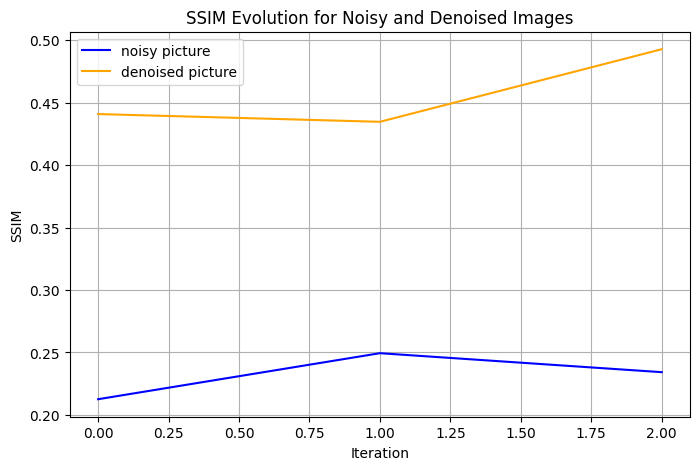

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# ✅ Kullanılacak belirli görüntü indeksleri
selected_indices = ["00001", "00002", "00003"]  # İşlenmesini istediğin görüntüler

# ✅ Veri setinin bulunduğu klasör
image_folder = "data/samples_ffhq/"
result_folder = "resultsMotion/"

# ✅ SSIM hesaplama fonksiyonu
def myssim(x, y):
    """
    SSIM hesaplama fonksiyonu.

    x: Tahmini görüntü (tensör)
    y: Gerçek görüntü (tensör)
    """
    x_np = x.permute(1, 2, 0).numpy()  # Tensörü numpy dizisine çevir (H, W, C)
    y_np = y.permute(1, 2, 0).numpy()  # Tensörü numpy dizisine çevir (H, W, C)

    ssim_value = ssim(x_np, y_np, win_size=11, channel_axis=2, data_range=1.0)  # SSIM hesapla
    return ssim_value


# ✅ Görüntüyü yükleyip PyTorch tensörüne çevirme fonksiyonu
def load_image_as_tensor(image_path, target_size=(256, 256)):
    """Görüntüyü aç, boyutunu target_size'a ayarla, normalize et ve PyTorch tensörüne dönüştür."""
    img = Image.open(image_path).convert("RGB")  # RGB'ye çevir
    img = img.resize(target_size)  # Boyutları eşitle
    img = np.array(img).astype(np.float32) / 255.0  # Normalize et (0-1)
    img = torch.tensor(img).permute(2, 0, 1)  # Kanal sırasını (C, H, W) yap
    return img

# ✅ Sonuçları saklamak için boş listeler
ssim_noisy_all = []
ssim_denoised_all = []

# ✅ SSIM hesaplamalarını yap
for img_id in selected_indices:
    original = os.path.join(image_folder, f"{img_id}.png")
    noisy = os.path.join(result_folder, f"noisy_image_{int(img_id[-1]) - 1}.png")
    rec_x = os.path.join(result_folder, f"reconstructed_x_{int(img_id[-1]) - 1}.png")
    rec_z = os.path.join(result_folder, f"reconstructed_z_{int(img_id[-1]) - 1}.png")

    # Görselleri yükle ve tensöre çevir
    x0 = load_image_as_tensor(original)
    x_noisy = load_image_as_tensor(noisy)
    x_rec_x = load_image_as_tensor(rec_x)
    x_rec_z = load_image_as_tensor(rec_z)

    # ✅ SSIM hesaplamaları
    ssim_noisy_true = myssim(x_noisy, x0)
    ssim_recx_true = myssim(x_rec_x, x0)
    ssim_recz_true = myssim(x_rec_z, x0)

    # Sonuçları listeye ekle
    ssim_noisy_all.append(ssim_noisy_true)
    ssim_denoised_all.append(ssim_recx_true)  # X rekonstrüksiyonu üzerinden alıyoruz

# ✅ Sonuçları terminalde yazdır
print("\n📊 **SSIM Sonuçları** 📊")
for i, img_id in enumerate(selected_indices):
    print(f"Image {img_id}: SSIM Noisy vs True = {ssim_noisy_all[i]:.4f}, SSIM Denoised vs True = {ssim_denoised_all[i]:.4f}")

# ✅ SSIM Grafiği
plt.figure(figsize=(8, 5))
plt.plot(ssim_noisy_all, label="noisy picture", color="blue")
plt.plot(ssim_denoised_all, label="denoised picture", color="orange")
plt.xlabel("Iteration")
plt.ylabel("SSIM")
plt.title("SSIM Evolution for Noisy and Denoised Images")
plt.legend()
plt.grid(True)
plt.show()



📊 **FID Sonuçları** 📊
╒════╤════════════╤═══════════════════════╤═════════════════════════════════╤═════════════════════════════════╤══════════════════════════════════╤══════════════════════════════════╕
│    │   Image ID │   FID (Noisy vs True) │   FID (Reconstructed X vs True) │   FID (Reconstructed Z vs True) │   FID (Noisy vs Reconstructed X) │   FID (Noisy vs Reconstructed Z) │
╞════╪════════════╪═══════════════════════╪═════════════════════════════════╪═════════════════════════════════╪══════════════════════════════════╪══════════════════════════════════╡
│  0 │      00001 │               395.972 │                         54.6286 │                        27.7627  │                          215.196 │                          239.977 │
├────┼────────────┼───────────────────────┼─────────────────────────────────┼─────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│  1 │      00002 │               786.499 │                        

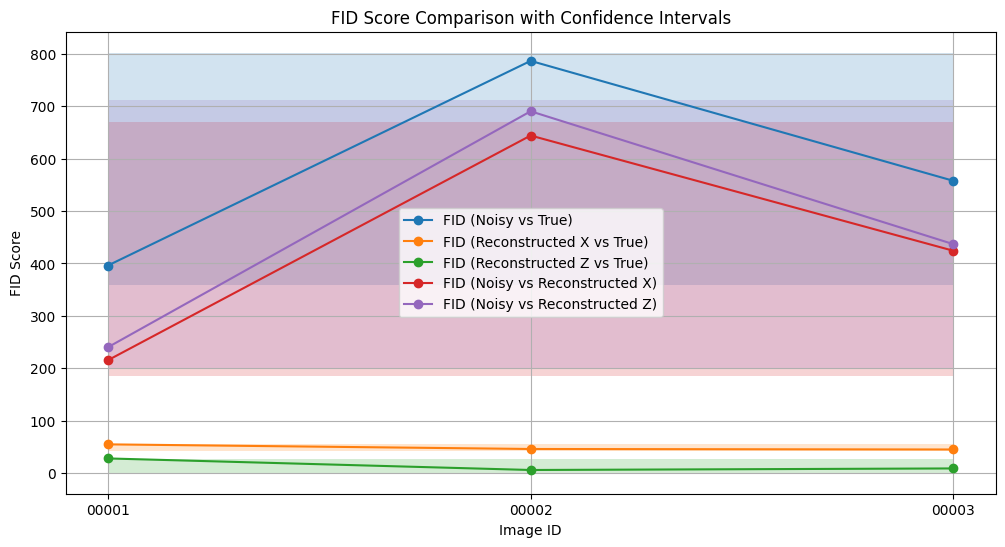

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.stats import sem  # Standart hata hesaplamak için
from PIL import Image
from tabulate import tabulate

# ✅ 1. Görselleri yükleyip işleme hazırlayan fonksiyon
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).resize((299, 299))
    img = img.convert("RGB")
    return np.array(img).astype(np.float32)

# ✅ 2. PyTorch olmadan FID hesaplama fonksiyonu
def calculate_fid_nopytorch(image1_path, image2_path):
    img1 = load_and_preprocess_image(image1_path)
    img2 = load_and_preprocess_image(image2_path)
    img1 = img1.reshape(-1, 3)
    img2 = img2.reshape(-1, 3)
    mu1, sigma1 = np.mean(img1, axis=0), np.cov(img1, rowvar=False)
    mu2, sigma2 = np.mean(img2, axis=0), np.cov(img2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# ✅ 3. Görüntü dosyalarının yollarını belirleyelim
image_ids = ["00001", "00002", "00003"]
fid_results = []

for img_id in image_ids:
    original = f"data/samples_ffhq/{img_id}.png"
    noisy = f"resultsMotion/noisy_image_{int(img_id[-1]) - 1}.png"
    rec_x = f"resultsMotion/reconstructed_x_{int(img_id[-1]) - 1}.png"
    rec_z = f"resultsMotion/reconstructed_z_{int(img_id[-1]) - 1}.png"

    fid_noisy_true = calculate_fid_nopytorch(original, noisy)
    fid_recx_true = calculate_fid_nopytorch(original, rec_x)
    fid_recz_true = calculate_fid_nopytorch(original, rec_z)
    fid_noisy_recx = calculate_fid_nopytorch(noisy, rec_x)
    fid_noisy_recz = calculate_fid_nopytorch(noisy, rec_z)

    fid_results.append([img_id, fid_noisy_true, fid_recx_true, fid_recz_true, fid_noisy_recx, fid_noisy_recz])

# ✅ 4. Sonuçları bir tablo olarak düzenleyelim
fid_df = pd.DataFrame(fid_results, columns=[
    "Image ID",
    "FID (Noisy vs True)",
    "FID (Reconstructed X vs True)",
    "FID (Reconstructed Z vs True)",
    "FID (Noisy vs Reconstructed X)",
    "FID (Noisy vs Reconstructed Z)"
])

# ✅ 5. Confidence Interval hesaplama fonksiyonu
def confidence_interval(data):
    mean = np.mean(data)
    error = 1.96 * sem(data)  # 95% güven aralığı
    return mean, mean - error, mean + error

# ✅ 6. Confidence Interval hesapla
confidence_intervals = {}
for col in fid_df.columns[1:]:  # "Image ID" hariç tüm kolonlar için
    mean, lower, upper = confidence_interval(fid_df[col])
    confidence_intervals[col] = [mean, lower, upper]

confidence_df = pd.DataFrame(confidence_intervals, index=["Mean", "Lower CI", "Upper CI"])

# ✅ 7. Sonuçları terminalde yazdır
print("\n📊 **FID Sonuçları** 📊")
print(tabulate(fid_df, headers="keys", tablefmt="fancy_grid"))
print("\n📌 **Confidence Intervals (95%)**")
print(tabulate(confidence_df, headers="keys", tablefmt="fancy_grid"))

# ✅ 8. Sonuçları görselleştirme (Chart oluşturma)
plt.figure(figsize=(12, 6))
for col in fid_df.columns[1:]:
    mean, lower, upper = confidence_interval(fid_df[col])
    plt.plot(fid_df["Image ID"], fid_df[col], marker='o', label=col)
    plt.fill_between(fid_df["Image ID"], lower, upper, alpha=0.2)  # Güven aralığını çiz

plt.xlabel("Image ID")
plt.ylabel("FID Score")
plt.title("FID Score Comparison with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
%cd ../../../..


/content


In [ ]:
%cd unzipped_motion/content/PnP-SGS/PnP-SGS/

/content/unzipped_motion/content/PnP-SGS/PnP-SGS


In [ ]:
import shutil
from google.colab import files

# Define the source folder and zip file name
source_folder = "/content"
zip_file = "/content/PnP-SGS-GaussianBlur-MotionBlur.zip"

# Zip the folder
shutil.make_archive(zip_file.replace(".zip", ""), 'zip', source_folder)

# Download the zip file
files.download(zip_file)